# Matching the Collection Title with Snippet Based on Similarity(SentenceTransformer)

- Adjust the threashold to manipulate the level of similrity desired between the snippet and the matched collection title


In [4]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import numpy as np
from collections import Counter

#### Find the most similar collection title and the respective score for each snippet -> snippets_similarity_score_with_title.csv
This dataset could be used for examining how the machine learning algorithm matches the snippet, which does not have a standardized way for referencing the Archives of American Art collection title.

In [5]:
# Load Data
collection_df = pd.read_csv("collection-titles.csv")
collection_titles = collection_df["collection_title"].dropna().tolist()  

search_result_df = pd.read_csv("search-results-annabel.csv")
search_result_df = search_result_df.drop_duplicates(subset=['url'], keep='first') # Drop duplicate publications


In [6]:
#clean and rename column for the search_result_df, split each cell of the snippets column into a list of snippets
search_result_df.rename(columns={" snippets": "snippets"}, inplace=True)
search_result_df["snippets"] = search_result_df["snippets"].fillna("")

In [ ]:
# Extract snippets_content column
snippets_content = search_result_df["snippets"].str.split("{") # Drop NaN values
snippets_content_list = [item for sublist in snippets_content for item in sublist]

model = SentenceTransformer('all-MiniLM-L6-v2')
# Convert text data to embeddings
collection_embeddings = model.encode(collection_titles, convert_to_tensor=True)
snippets_embeddings = model.encode(snippets_content_list, convert_to_tensor=True)

# Compute cosine similarity matrix
similarities = util.pytorch_cos_sim(collection_embeddings, snippets_embeddings).cpu().numpy()

In [8]:
# Assign each snippet to the best-matching collection title
best_match_indices = np.argmax(similarities, axis=0)  # Get best title for each snippet
best_scores = np.max(similarities, axis=0)  # Get highest similarity score for each snippet

# Define a similarity threshold
threshold = 0.65  # Adjust as needed

# Store results with filtering
matched_pairs = [
    (collection_titles[best_match_indices[i]], snippets_content_list[i], best_scores[i])
    for i in range(len(snippets_content_list)) if best_scores[i] >= threshold
]

# Create a DataFrame of matches
results_df = pd.DataFrame(matched_pairs, columns=["Collection Title", "Snippet", "Similarity Score"])
results_df.to_csv("snippets_similarity_score_with_title.csv", index=False)

#### Find the snippet and collection title matching -> snippets_with_title.csv
Each publication on internet archives contains multiple snippets, and each snippet can be matched with one collection title. The output dataset contains the summary of all snippets for one publication referencing the Archives of American Art and the list of all collection titles that got paired with those snippets separated by “|”. 

In [9]:
# Split snippets in each row using "{"
search_result_df["snippets_list"] = search_result_df["snippets"].apply(lambda x: x.split("{"))
search_result_df["snippets_list"] = search_result_df["snippets_list"].apply(lambda x: x[1:]) # Remove "[" at the beginning

# Flatten all snippets into a list for processing
all_snippets = [snippet for snippets in search_result_df["snippets_list"] for snippet in snippets]

# Load the model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Convert text data to embeddings
collection_embeddings = model.encode(collection_titles, convert_to_tensor=True)
snippets_embeddings = model.encode(all_snippets, convert_to_tensor=True)

# Compute cosine similarity matrix
similarities = util.cos_sim(collection_embeddings, snippets_embeddings).cpu().numpy()

# Assign each snippet the best-matching collection title
best_match_indices = np.argmax(similarities, axis=0)
best_scores = np.max(similarities, axis=0)

# Define similarity threshold
threshold = 0.65  # Adjust as needed

# Store matches in a dictionary mapping snippets to their best-matching titles
snippet_to_title = {
    all_snippets[i]: collection_titles[best_match_indices[i]] if best_scores[i] >= threshold else "No Match"
    for i in range(len(all_snippets))
}

# For the no match snippets, we will try to find the collection title by checking if the collection title is directly in the snippet
for i in all_snippets:
    if snippet_to_title[i] == "No Match":
        for j in collection_titles:
            if j.split(",")[0].lower() in i.lower():
                snippet_to_title[i] = j
                break

# Function to map snippets in each row back to their matched titles
def map_snippets_to_titles(snippet_list):
    return [snippet_to_title.get(snippet, "No Match") for snippet in snippet_list]

# Apply function to get matched titles for each row
search_result_df["matched_collection_title"] = search_result_df["snippets_list"].apply(lambda x: "| ".join(map_snippets_to_titles(x)))

# Save the updated DataFrame with matched titles
search_result_df.drop(columns=["snippets_list"], inplace=True)  # Drop intermediate column
search_result_df.to_csv("snippets_with_title.csv", index=False)

#### Find the occurence of collection title on citations -> collection_title_counts_sorted.csv
This dataset contains the total occurrence of each collection title in publications. 

“Total Count”:  the number of occurrences of that title in the whole corpus of internet archive publications. 

“Unique Count”: As some publications have cited a single Archives of American Art collection multiple times, this “Unique Count” column only counts those multiple citations in one publication once.


In [10]:
# Flatten all matched titles into a list while preserving multiple instances
all_matched_titles = [
    title.strip() for sublist in search_result_df["matched_collection_title"].str.split("|") for title in sublist
]

# Total Count: Counts every occurrence of a title (including duplicates within a row)
total_counts = {title: all_matched_titles.count(title) for title in collection_titles}

# Unique Count: Counts each title only **once per row**
unique_counts = {
    title: search_result_df["matched_collection_title"].apply(lambda x: title in x).sum()
    for title in collection_titles
}

# Convert to DataFrame
count_df = pd.DataFrame({
    "Title": collection_titles,
    "Total Count": [total_counts[title] for title in collection_titles],
    "Unique Count": [unique_counts[title] for title in collection_titles]
})

In [14]:
# export the title occurence count to a the collection_title_counts.csv and the sorted version to collection_title_counts_sorted.csv
count_df.to_csv("collection_title_counts.csv", index=False)
collection_title_counts_sorted_df = pd.DataFrame(count_df.sort_values(by="Total Count", ascending=False))
collection_title_counts_sorted_df.to_csv("collection_title_counts_sorted.csv", index=False)


Limitation: The similarity model is not 100% accurate for matching the collection title with the snippet, as people reference collections differently and may not be in a standard recognizable format. It might have some errors matching to the correct collection title. However, it does increase the chance that the snippet will get a match with the existing collection title compared to directly finding the collection title inside the snippet. Using the similarity model method captures a large portion of citations that did not include the direct collection name. The balance between matching accuracy and the number of matches could be tailored by adjusting the threshold of the similarity model.

## Visualizaiton


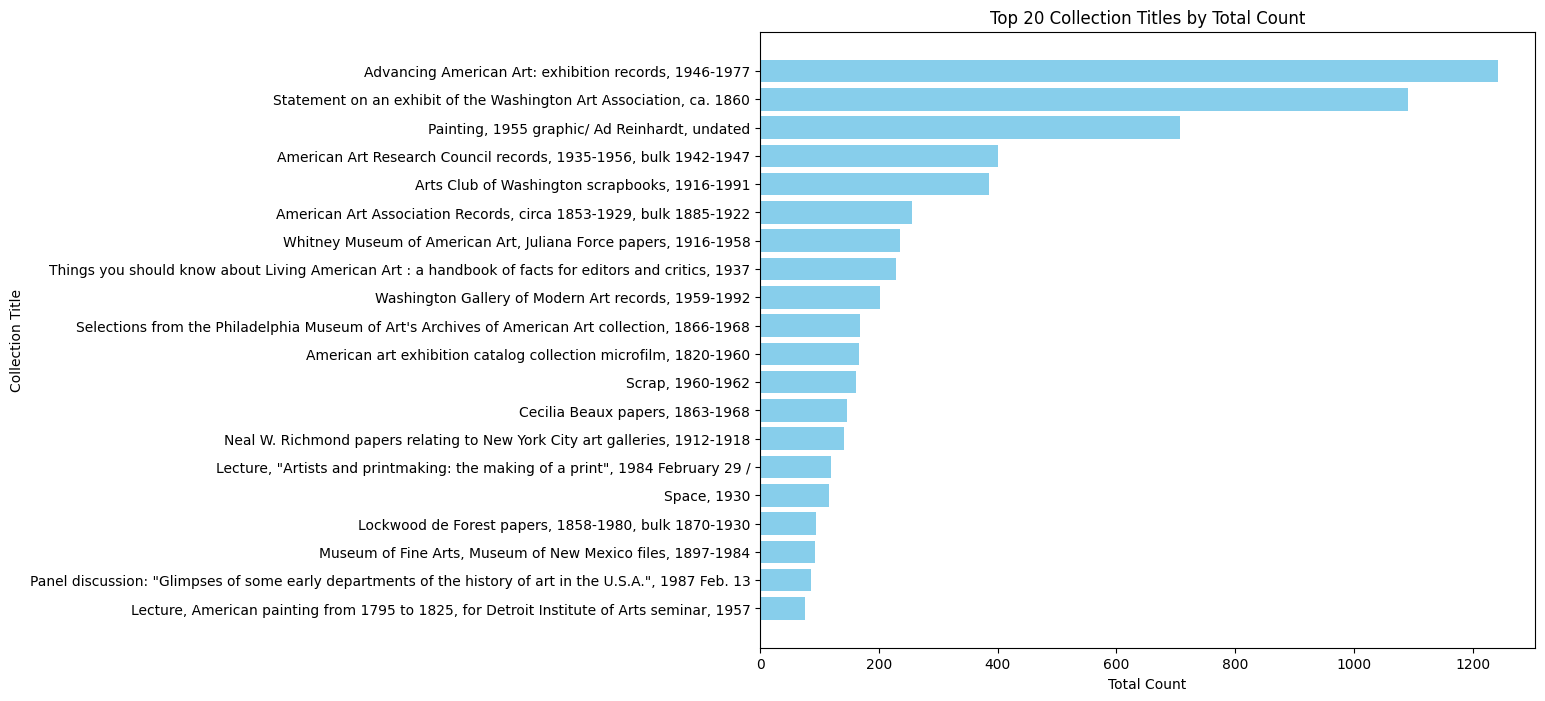

In [15]:
import matplotlib.pyplot as plt

# Plot the top 20 collection titles by total count
top_n = 20
top_titles = collection_title_counts_sorted_df.head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(top_titles['Title'], top_titles['Total Count'], color='skyblue')
plt.xlabel('Total Count')
plt.ylabel('Collection Title')
plt.title('Top 20 Collection Titles by Total Count')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.show()

The most snippet in the top 2 collection titles did not get matched to the correct title due to the fact that the snippet did not mention any actual collection. 

Here is a sample demonstration of the false matching for the top 2 title:
‘Advancing American Art: exhibition records, 1946-1977’ :  “'Page 628': 'archives of american art (Smithsonian)'},” or 'Page 140': 'Archives of American Art, Smithsonian Institution, Washington, D.C.'}]
‘Statement on an exhibit of the Washington Art Association, ca. 1860’ : 'Page 140': 'Archives of American Art, Smithsonian Institution, Washington, D.C.'}]

Starting from the top 3 collection titles, they have meaningful matches.
